# PART - 1: PROJECT NOTEBOOK

In [65]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

In [66]:
data = pd.read_csv('data_public.csv')

X = data.drop(['Class'], axis=1)
y = data[['Class']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3)

In [67]:
data_train = pd.concat([X_train,
                        y_train],
                       axis=1)
data_train.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
135394,235.116795,-2.712434,205.586366,-14.946727,142.694080,85.622676,117.348939,203.008643,85.342685,141.013906,220.648419,-0.671737,-15.964983,143.586514,148.863879,3
722758,-33.525835,-16.344699,10.214548,17.969837,-27.117769,-26.795205,-6.380988,-28.885772,-8.365208,31.265186,8.177464,2.547256,-53.914151,-6.616365,1.998724,2
994804,-35.203185,-13.131988,14.492143,19.744163,-26.476466,-22.521795,-1.625952,-26.275618,-9.238235,22.552594,3.296418,7.065057,-57.340774,-5.527832,0.403900,2
366493,-29.512082,-11.637268,13.038396,22.505602,-23.554941,-23.331187,5.549490,-26.452207,-9.924848,26.039084,5.931882,5.545118,-55.960276,-3.723950,-1.786022,2
208429,-36.953865,-15.617127,13.047142,21.851191,-22.427807,-28.917086,-8.301286,-27.920392,-6.128945,26.099989,5.460212,0.642603,-49.754879,-9.017634,0.540634,2


In [68]:
data_test = pd.concat([X_test,
                       y_test],
                      axis=1)
data_test.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
394756,-29.275052,-12.005811,10.452010,13.602723,-23.940079,-32.402546,-3.571024,-27.664046,-6.306133,13.911701,1.442536,2.343948,-54.540636,-5.302770,-3.925450,2
534672,-64.264512,-48.831986,-32.686563,-114.317004,-9.829118,-139.274318,-52.881695,-9.599464,55.419653,-97.140403,43.239661,-39.354755,-53.734709,31.684802,56.812125,1
870296,225.347950,-10.820757,228.746193,-15.324858,132.401284,85.978145,131.931104,198.222381,91.846836,143.761429,218.535418,-5.100359,-20.213655,139.720250,143.022551,3
1075880,-59.933022,-36.368120,-44.748508,-103.410730,-13.440002,-136.226911,-53.316606,-0.919429,47.322239,-100.159412,47.756945,-43.202897,-57.525304,26.024963,61.689481,1
977580,229.955663,-19.411655,205.342353,-15.280952,134.952594,84.002441,127.903905,204.935727,80.985849,125.470944,231.813530,-1.987664,-8.582165,148.039307,144.346384,3


In [69]:
data_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

data_transformer = Pipeline(steps=[
    ('imputer',
     SimpleImputer(strategy='mean')),
    ('scaler',
     StandardScaler())
])

columns = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O')
preprocessor = ColumnTransformer(transformers=[
    ('columns',
     data_transformer,
     data_features)
])
classifier = DecisionTreeClassifier()

In [70]:
pipeline = Pipeline([
    ('precprocessor',
     preprocessor),
    ('classifier',
     classifier)
])

pipeline.fit(iris_train,
             iris_train["Class"]);

In [71]:
pipeline.predict(X_test)

array([2, 1, 3, ..., 2, 2, 1], dtype=int64)

In [72]:
input_types = dict([(x, FloatTensorType([1, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline,
                                 'pipeline_data_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("pipeline_data.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.


In [73]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("pipeline_data.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

predict [2 1 3 ... 2 2 1]


(-0.5, 4457.5, 5321.5, -0.5)

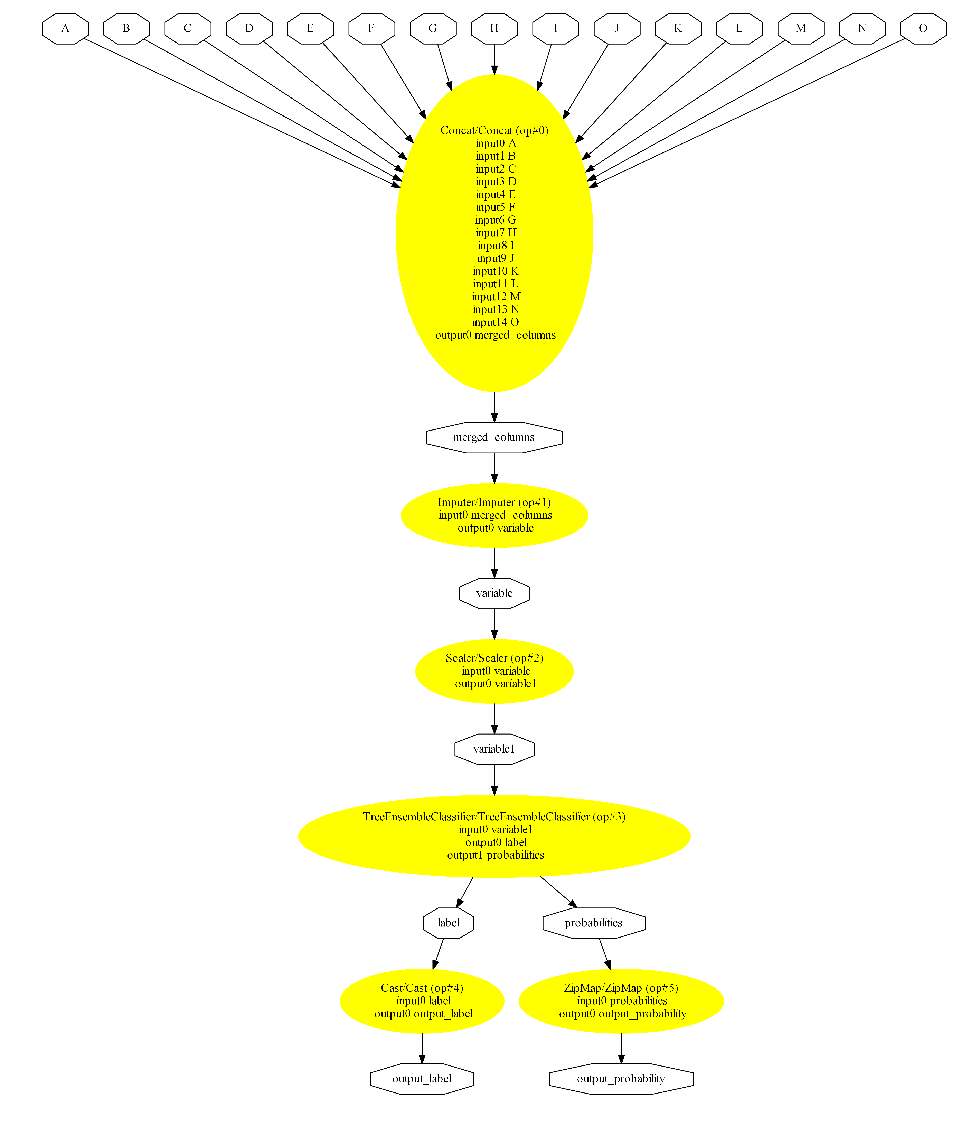

In [74]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))
pydot_graph.write_dot("pipeline_data.dot")

os.system('dot -O -Gdpi=300 -Tpng pipeline_data.dot')

image = plt.imread("pipeline_data.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')

# PART - 2 :- PROJECT REPORT

### Abstract - 
 Construct an ONNX pipeline, with the use of a classifier model and feature engineering. After this, the created .ONNX file is utilized and implemented on an actual data-set to build outcomes.

### Overview:
Here, provided a dataset required to be deployed an efficient model and onnx file with the use of the pipeline. Now, the data is processed and imputed with "mean" of the particular columns. After that,the Random Forest model is deployed for the provided dataset. The outcome of this project will be an .onnx file.

### Data Processing:
 The data in the provided dataset has notable bulk of negative values for each features and 15 features. The data is imputed with "mean" strategy of every column. An sklearn pipeline is generated with column transformation and classifier.

### Data Analysis: 
Here, All of the features have highl corrrelation. For this, an correlation plot is plotted. Among them the best features are then selected.

### Model Training:
The model selected for this data set is Desicision Tree. This model neglects an over-fitting the data.

Here, the data set was spilt regarding the stratified sampling with the use of 'class'. The data was then split into testing(validation) and training data-set into the 70:30 ratio. After that, the model was trained with the use of the training data. The vary important features of the model were recorgnized. 

### Model Validation:
The model was validated with the use of the testing data set which was out-of-sample data from the stratified sampling which was not used throughout the model training. The accuracy and f1 score was then estimated.

### Conclusion:
 The model used in project was Decision Tree. The pipeline was arranged to pre-process the data from the diven file and impute its values and move forward to the model generated. The accuracy and f1 score of the model was estimated appropriately. 

### Data Sources:
 Here, along with project, the CSV file was given.

### Source Code:
 The references for Decision Tree model building and parameter tuning are referenced from these links given below: 
- https://www.datacamp.com/community/tutorials/decision-tree-classification-python 
- https://chrisalbon.com/machine_learning/trees_and_forests/decision_tree_classifier/

### Bibliography:
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/feature_selection.html